# Load dataset

In [2]:
import pandas as pd

data = pd.read_csv("../data/train.csv")
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# Data cleaning

## Handling missing data

In [3]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

# # Impute missing values (if any)
# data.fillna(data.median(), inplace=True)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


## Handling outliers

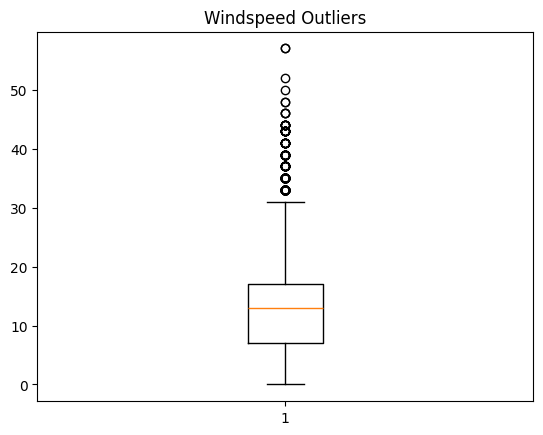

In [4]:
import matplotlib.pyplot as plt

# Box plot to detect outliers in windspeed
plt.boxplot(data['windspeed'])
plt.title('Windspeed Outliers')
plt.show()

# Cap windspeed at a maximum threshold if necessary
data['windspeed'] = data['windspeed'].clip(upper=40)


## Erroneous values

In [5]:
# Remove rows with negative or erroneous values
data = data[data['temp'] >= 0]

# Feature Engineering

## Datetime features

In [6]:
# Convert 'datetime' column to datetime object
data['datetime'] = pd.to_datetime(data['datetime'])

# Create new features
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month


## Weather patterns

In [7]:
# Create binary weather features
data['is_clear_weather'] = (data['weather'] == 1).astype(int)
data['is_rainy_weather'] = (data['weather'] >= 3).astype(int)

## Holiday and working day interactions

In [8]:
# Create a combined feature for holidays and working days
data['is_holiday_workingday'] = ((data['holiday'] == 1) & (data['workingday'] == 1)).astype(int)

## Drop unwanted cols

In [9]:
data.drop(columns=["datetime"], inplace=True)

# Split the dataset

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = data.drop(columns=["count"])  # Features (all columns except 'count')
y = data["count"]  # Target variable

# Perform an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the split
print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")

Training data size: (8708, 16)
Testing data size: (2178, 16)


# Model building

2024/10/07 22:24:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model training complete. MAE: 3.6803246669967646, RMSE: 7.088694908391736


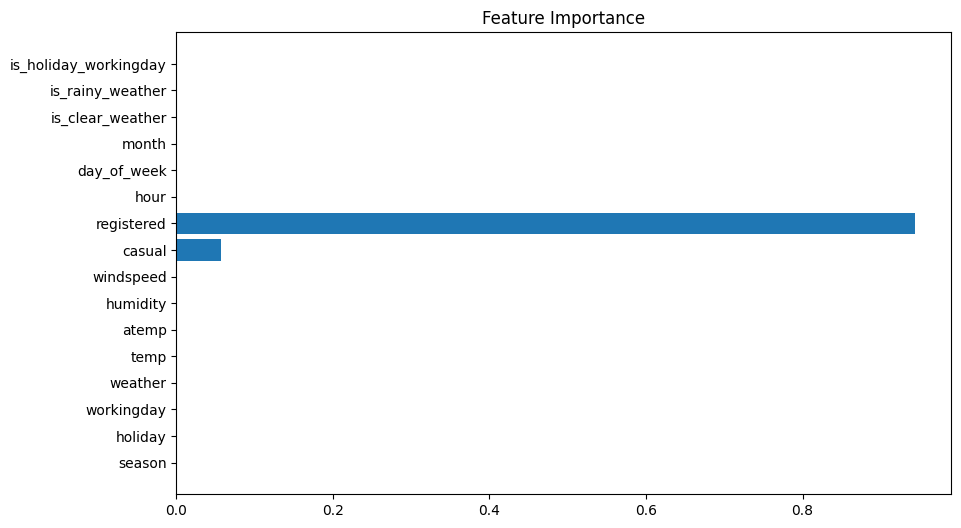

In [11]:
import mlflow
import mlflow.sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define the model
model = DecisionTreeRegressor(max_depth=10, random_state=42)

# Start an MLFlow run
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("model_type", "DecisionTreeRegressor")
    mlflow.log_param("max_depth", 10)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    # Log evaluation metrics
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    
    # Plot and log feature importance as an artifact
    feature_importances = model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.barh(X_train.columns, feature_importances)
    plt.title("Feature Importance")
    plt.savefig("feature_importance.png")
    
    # Log the artifact (the feature importance plot)
    mlflow.log_artifact("feature_importance.png")
    
    # Log the model itself
    mlflow.sklearn.log_model(model, "model")
    
print(f"Model training complete. MAE: {mae}, RMSE: {rmse}")


# Hyperparameter tuning

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import mlflow
import mlflow.sklearn

# Define the model and the hyperparameter grid
model = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Start an MLFlow run for hyperparameter tuning
with mlflow.start_run():
    # Perform grid search
    grid_search.fit(X_train, y_train)
    
    # Log the best hyperparameters
    best_params = grid_search.best_params_
    mlflow.log_param("best_max_depth", best_params['max_depth'])
    mlflow.log_param("best_min_samples_split", best_params['min_samples_split'])
    
    # Log the best score (cross-validated)
    best_score = -grid_search.best_score_  # Convert to positive since we used neg_mean_squared_error
    mlflow.log_metric("best_cross_val_score", best_score)
    
    # Log the final model
    best_model = grid_search.best_estimator_
    mlflow.sklearn.log_model(best_model, "best_model")
    
    # Evaluate the model on the test set and log the result
    test_predictions = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    mlflow.log_metric("test_RMSE", test_rmse)
    
print(f"Best Hyperparameters: {best_params}")
print(f"Test RMSE: {test_rmse}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits


2024/10/07 22:24:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Hyperparameters: {'max_depth': 15, 'min_samples_split': 10}
Test RMSE: 6.645717111734768


## RandomizedSearchCV

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the hyperparameter distributions
param_distributions = {
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 20)
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, 
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=1)

# Perform RandomizedSearchCV with MLFlow tracking
with mlflow.start_run():
    random_search.fit(X_train, y_train)
    
    # Log the best hyperparameters and metrics
    best_params = random_search.best_params_
    mlflow.log_param("best_max_depth", best_params['max_depth'])
    mlflow.log_param("best_min_samples_split", best_params['min_samples_split'])
    
    best_score = -random_search.best_score_  # Convert to positive MSE
    mlflow.log_metric("best_cross_val_score", best_score)
    
    # Log the best model
    best_model = random_search.best_estimator_
    mlflow.sklearn.log_model(best_model, "best_model")
    
    # Evaluate and log test set performance
    test_predictions = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    mlflow.log_metric("test_RMSE", test_rmse)

print(f"Best Hyperparameters: {best_params}")
print(f"Test RMSE: {test_rmse}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/pa/ppt/projects/mlflow-demo/mlops-env/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
2024/10/07 22:24:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Hyperparameters: {'max_depth': 15, 'min_samples_split': 5}
Test RMSE: 6.240402041286485


# Logging metrics

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow

# Evaluate the model
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Log the metrics using MLFlow
with mlflow.start_run():
    mlflow.log_metric("R2", r2)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")


R²: 0.999
RMSE: 6.240
MAE: 2.891


# Save best model

In [32]:
import mlflow
import mlflow.sklearn

# Save the best model using MLFlow
with mlflow.start_run():
    # Take the first row of the training dataset as the model input example.
    input_example = X_train.iloc[[0]]
    # The signature is automatically inferred from the input example and its predicted output.

    mlflow.sklearn.log_model(best_model, "bike_prediction_model", input_example=input_example)
    print("Model saved successfully!")


/home/pa/ppt/projects/mlflow-demo/mlops-env/lib/python3.9/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Model saved successfully!


# Register the model

In [33]:
import mlflow
import mlflow.sklearn

# Start an MLFlow run
with mlflow.start_run() as run:
    # Take the first row of the training dataset as the model input example.
    input_example = X_train.iloc[[0]]
    # The signature is automatically inferred from the input example and its predicted output.

    mlflow.sklearn.log_model(best_model, "bike_prediction_model", input_example=input_example)

    # Register the model in the model registry
    model_uri = f"runs:/{run.info.run_id}/bike_prediction_model"
    mlflow.register_model(model_uri, "BikePredictionModel")


/home/pa/ppt/projects/mlflow-demo/mlops-env/lib/python3.9/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'BikePredictionModel'.
Created version '1' of model 'BikePredictionModel'.


# Transition registered model to different stages

In [34]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Transition the model to staging
client.transition_model_version_stage(
    name="BikePredictionModel",
    version=1,
    stage="Staging"
)

# After testing, promote the model to production
client.transition_model_version_stage(
    name="BikePredictionModel",
    version=1,
    stage="Production"
)


/tmp/ipykernel_66880/3937700170.py:6: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(
/tmp/ipykernel_66880/3937700170.py:13: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1728322310640, current_stage='Production', description=None, last_updated_timestamp=1728322452307, name='BikePredictionModel', run_id='1916b4281ddd4dd68b13a6481b764d98', run_link=None, source='file:///home/pa/ppt/projects/mlflow-demo/bike-prediction-mlops/notebooks/mlruns/0/1916b4281ddd4dd68b13a6481b764d98/artifacts/bike_prediction_model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [35]:
# List all versions of the registered model
model_versions = client.search_model_versions("name='BikePredictionModel'")
for version in model_versions:
    print(f"Version: {version.version}, Stage: {version.current_stage}")


Version: 1, Stage: Production
